In [128]:
import torch
import torchvision.transforms as transforms
import timm.data.transforms as timm_transforms
from timm.data.auto_augment import rand_augment_transform as AutoAugment
from timm.data.random_erasing import RandomErasing

from PIL import Image
import requests
from io import BytesIO


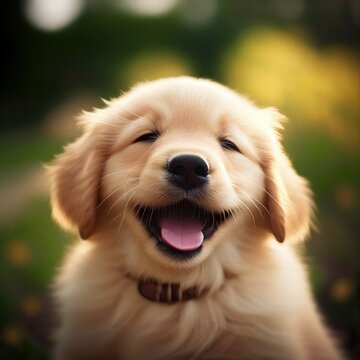

In [129]:
IMG_URL = "https://t4.ftcdn.net/jpg/05/68/28/05/360_F_568280532_Bvxwd66M3Y22vVeJ3VRqHRAqrdNfJo7o.jpg"

response = requests.get(IMG_URL)
image = Image.open(BytesIO(response.content))
image

In [130]:
### FROM FOCALNET PAPER, IMAGENET AUGMENTAION:

    # | Color Jitter Factor           | 0.4      | 
    # | Auto-augmentation             | rand-m9-mstd0.5-inc1 | 
    # | Random Erasing Probability    | 0.25     | 
    # | Random Erasing Mode           | Pixel    | 
    # | Mixup α                       | 0.8      |
    # | Cutmix α                      | 0.8      |
    # | Mixup Probability             | 1.0      |
    # | Mixup Switch Probability      | 0.5      |
    # | Stochastic Drop Path Rate     | 0.2/0.3/0.5 |
    # | Label Smoothing               | 0.1      |


## setting up variables

color_jitter_factor = 0.4
auto_augmentation_policy = "rand-m9-mstd0.5-inc1"
translate_const = 117
PIL_img_mean = (124, 116, 104)
random_erasing_probability = 0.25
random_erasing_mode = "pixel"
mixup_alpha = 0.8
cutmix_alpha = 0.8
mixup_probability = 1.0
mixup_switch_probability = 0.5
stochastic_drop_path_rate = [0.2, 0.3, 0.5]
label_smoothing = 0.1
num_classes = 1000

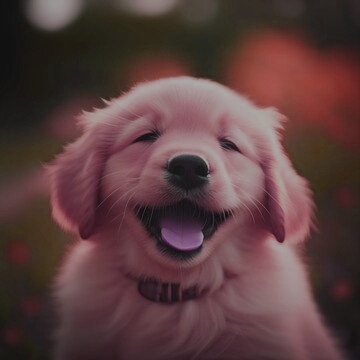

In [131]:
 # | Color Jitter Factor           | 0.4      | 

color_jitter = transforms.ColorJitter(brightness=color_jitter_factor, 
                                      contrast=color_jitter_factor,
                                      saturation=color_jitter_factor, 
                                      hue=color_jitter_factor)

img_aug = color_jitter(image)
img_aug

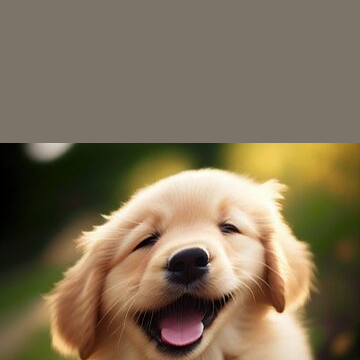

In [136]:
# | Auto-augmentation             | rand-m9-mstd0.5-inc1 | 

 
auto_augment = AutoAugment(
    config_str=auto_augmentation_policy, 
    hparams={'translate_const': translate_const, 'img_mean': PIL_img_mean})

img_aug = auto_augment(image)
img_aug

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


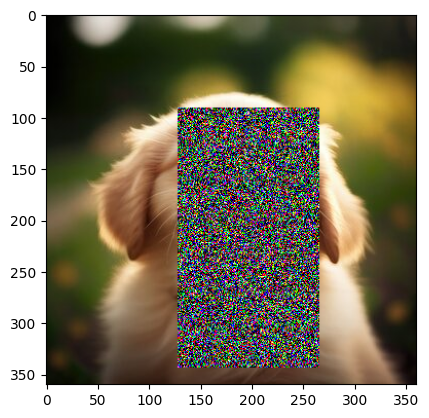

In [143]:
    # | Random Erasing Probability    | 0.25     | 
    # | Random Erasing Mode           | Pixel    | 


import matplotlib.pyplot as plt


random_erasing = transforms.RandomErasing(p=random_erasing_probability, value='random', inplace=False)
img_aug = random_erasing(transforms.ToTensor()(image))
plt.imshow(img_aug.permute(1, 2, 0))


In [123]:
    # | Mixup α                       | 0.8      |
    # | Cutmix α                      | 0.8      |
    # | Mixup Probability             | 1.0      |
    # | Mixup Switch Probability      | 0.5      |
    # | Label Smoothing               | 0.1      |

# mixup have to be done on the fly; otherwise not possible



from torchvision import datasets



# Define the image URLs
image_urls = [
    "https://static1.squarespace.com/static/54e7a1a6e4b08db9da801ded/t/61eb41b698b5f077a9637a40/1642807755677/81.jpg?format=1500w",
    "https://images.pexels.com/photos/1170986/pexels-photo-1170986.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500",
    "https://www.shutterstock.com/image-photo/beach-ball-isolated-on-white-260nw-765739069.jpg",
    "https://www.hepper.com/wp-content/uploads/2021/11/golden-retriever_Shutterstock.jpg",
    "https://media.gettyimages.com/id/171554821/photo/golden-retriever-laying-down.jpg?s=612x612&w=gi&k=20&c=t9yx6QENxPRA_Jmm_xCwfZzDtjWVzvWDUsLxqEOyDag=",
    "https://img.freepik.com/free-photo/red-white-cat-i-white-studio_155003-13189.jpg?w=360"

    ]

# Define the labels for each image
labels = [2, 5, 8, 2, 2, 5]

# 2-> golden retrival, 5-> cat, 8-> ball



# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

# Define a custom dataset
class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, image_urls, labels, transform=None):
            self.image_urls = image_urls
            self.labels = labels
            self.transform = transform

        def __len__(self):
            return len(self.image_urls)

        def __getitem__(self, index):
            response = requests.get(self.image_urls[index])
            image = Image.open(BytesIO(response.content)).convert("RGB")
            if self.transform:
                image = self.transform(image)
            label = torch.tensor([self.labels[index]])
            # print(label.shape)
            # print(image.shape)
            return image, label

# Create an instance of the custom dataset
dataset = CustomDataset(image_urls, labels, transform=transform)

# Create a data loader for the dataset
batch_size = 6
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Iterate over the data loader
for images, labels in dataloader:
        # Process the batch of images and labels
        print(images.shape)
        print(labels)
        print(labels.shape)


torch.Size([6, 3, 256, 256])
tensor([[2],
        [5],
        [8],
        [2],
        [2],
        [5]])
torch.Size([6, 1])


In [124]:
import numpy as np


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

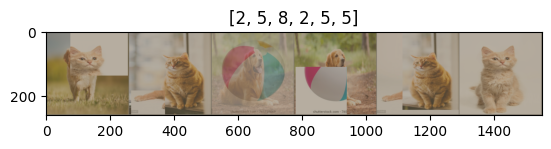

tensor([2, 5, 8, 2, 5, 5])


In [125]:
mixup_args = {
    'mixup_alpha': mixup_alpha,
    'cutmix_alpha': cutmix_alpha,
    'cutmix_minmax': None,
    'prob': mixup_probability,
    'switch_prob': mixup_switch_probability,
    'mode': 'elem',
    'label_smoothing': label_smoothing,
    'num_classes': num_classes}


from timm.data.mixup import Mixup
mixup_fn = Mixup(**mixup_args)

import torchvision

inputs, classes = mixup_fn(images, labels)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes.argmax(1)])
print(classes.argmax(1))

In [126]:
print(inputs.shape)
print(classes.shape)

torch.Size([6, 3, 256, 256])
torch.Size([6, 1000])


In [127]:
classes

tensor([[1.0000e-04, 1.0000e-04, 5.6392e-01,  ..., 1.0000e-04, 1.0000e-04,
         1.0000e-04],
        [1.0000e-04, 1.0000e-04, 1.0782e-01,  ..., 1.0000e-04, 1.0000e-04,
         1.0000e-04],
        [1.0000e-04, 1.0000e-04, 4.3596e-01,  ..., 1.0000e-04, 1.0000e-04,
         1.0000e-04],
        [1.0000e-04, 1.0000e-04, 5.7710e-01,  ..., 1.0000e-04, 1.0000e-04,
         1.0000e-04],
        [1.0000e-04, 1.0000e-04, 3.2002e-01,  ..., 1.0000e-04, 1.0000e-04,
         1.0000e-04],
        [1.0000e-04, 1.0000e-04, 3.8193e-02,  ..., 1.0000e-04, 1.0000e-04,
         1.0000e-04]])

In [ ]:


import torchvision.transforms as transforms

    # | Color Jitter Factor           | 0.4      | d
    # | Auto-augmentation             | rand-m9-mstd0.5-inc1 | 
    # | Random Erasing Probability    | 0.25     | 
    # | Random Erasing Mode           | Pixel    | 
    # | Mixup α                       | 0.8      |
    # | Cutmix α                      | 0.8      |
    # | Mixup Probability             | 1.0      |
    # | Mixup Switch Probability      | 0.5      |
    # | Stochastic Drop Path Rate     | 0.2/0.3/0.5 |
    # | Label Smoothing               | 0.1      |


color_jitter_factor = 0.4
color_jitter_transform = transforms.ColorJitter(brightness=color_jitter_factor, contrast=color_jitter_factor,
                                                saturation=color_jitter_factor, hue=color_jitter_factor)


# # Auto-augmentation
# auto_augmentation_transform = transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET)

# # Random Erasing
# random_erasing_probability = 0.25
# random_erasing_transform = transforms.RandomErasing(p=random_erasing_probability, value='random', inplace=False)



# # Mixup
# mixup_alpha = 0.8
# mixup_probability = 1.0
# mixup_switch_probability = 0.5
# mixup_transform = transforms.RandomMixup(probability=mixup_probability, switch_prob=mixup_switch_probability,
#                                          alpha=mixup_alpha)

# # Cutmix
# cutmix_alpha = 0.8
# cutmix_transform = transforms.RandomCutmix(probability=1.0, beta=cutmix_alpha)

# # Compose all transforms
# composed_transforms = transforms.Compose([
#     color_jitter_transform,
#     auto_augmentation_transform,
#     random_erasing_transform,
#     mixup_transform,
#     cutmix_transform,
#     transforms.ToTensor(),
# ])

# # Apply transforms to your dataset or image
# transformed_data = composed_transforms(your_data)






#### using function

In [5]:
import os

# Change the current directory to root directory
new_directory = "../"
os.chdir(new_directory)

# Verify the current directory has changed
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Updated Directory: /media/toma/2TB_30May2023/OBJECT_DETECTION_L/object_detection


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


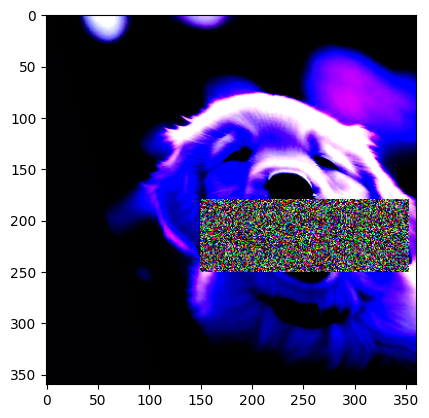

In [25]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor
from utils.augmentations import generate_transform_function

IMG_URL = "https://t4.ftcdn.net/jpg/05/68/28/05/360_F_568280532_Bvxwd66M3Y22vVeJ3VRqHRAqrdNfJo7o.jpg"

response = requests.get(IMG_URL)
image = Image.open(BytesIO(response.content))



image_processor = AutoImageProcessor.from_pretrained("configs/backbones/focalnet/preprocessor_config.json")
augmentation_config_path = "configs/augmentation_config_imagenet.json"


transforms_fn = generate_transform_function(image_processor, augmentation_config_path)
img_aug = transforms_fn(image)


plt.imshow(img_aug.permute(1, 2, 0))